In [46]:
import matplotlib.pyplot as plt                 # For normal plotting

# from mpl_toolkits.mplot3d import Axes3D         # For 3D plotting
# from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

import numpy as np                              # For maths

from scipy import ndimage                       # For image rotations
# from scipy import constants                     # For scientific constants
import scipy.interpolate                        # For importing data

import copy                                     # For manipulating data

import pandas                                   # For importing data

import imageio                                  # For creating gifs

# Plots appear embedded/windowed for inline/qt
%matplotlib inline

Generate scalar triangular prism

In [7]:
def generate_tri_pris(n = 100, size_n = 1,pi=1):
    """ 
    Generate triangular prism data (with missing slice)
    
    Input:
    n = number of nodes in each dimension (nxnxn grid)
    size_n = length in nm of each node
    
    Output:
    X,Y,Z,MX,MY,MZ = Gridded coordinates, gridded magnetisation
    """
    
    # Define gradient/intercept of bounding lines
    m1, c1 = 5, 100
    m2, c2 = 0, -25
    m3, c3 = -0.6, 0
    
    # Generate x,y,z value
    xs = np.linspace(-n/2,n/2,int(n/size_n))
    ys = np.linspace(-n/2,n/2,int(n/size_n))
    zs = np.linspace(-n/2,n/2,int(n/size_n))
    
    X,Y,Z = np.meshgrid(xs,ys,zs,indexing='ij')

    # Assign density
    data = []
    for x in xs:
        for y in ys:
            for z in zs:
                if y < (m1*x+c1) and y > (m2*x + c2) and y < (m3*x + c3) and ((z >-20 and z<-10) or (z>0 and z<40)):
                    p = pi
                    data.append([x,y,z,p])
                else:
                    p = 0
                    data.append([x,y,z,p])

    # Extract density
    P = np.take(data,3,axis=1)

    P = P.reshape(len(xs),len(ys),len(zs))
    
    return X,Y,Z,P

In [20]:
def plot_2d(X,Y,Z,P,s=5,size=0.1, width = 0.005, title=''):
    """
    Plot magnetisation data in 2D
    
    Input:
    x,y = 'Projected' 2D coordinates (nxn)
    u,v = 'Projected' 2D magnetisation (nxn)
    s = Quiver plot skip density
    size = Arrow length scaling
    width = Arrow thickness 
    
    Output:
    2D Plot of magnetisation:
    - Arrows show direction of M
    - Background color shows magnitude of M
    """
    # Project along z by averaging
    x_proj = np.mean(X,axis=2)
    y_proj = np.mean(Y,axis=2)
    z_proj = np.mean(Z,axis=2)
    p_proj = np.mean(P,axis=2)
    
    # Create figure
    fig,ax = plt.subplots(figsize=(6, 8))

    # Plot magnitude
    im1 = ax.imshow(np.flipud(p_proj.T),vmin=0,vmax=1,cmap='Blues',
                     extent=(np.min(x_proj),np.max(x_proj),np.min(y_proj),np.max(y_proj)))
    
    # Add colorbar and labels
    clb = fig.colorbar(im1,ax=ax,fraction=0.046, pad=0.04)
    ax.set_xlabel('x / nm',fontsize=14)
    ax.set_ylabel('y / nm',fontsize=14)
    ax.set_title(title, fontsize= 16)

#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
    
    plt.tight_layout()

In [32]:
def rotate_bulk(P,ax,ay,az):
    """ 
    Rotate magnetisation locations from rotation angles ax,ay,az 
    about the x,y,z axes (given in degrees) 
    
    NOTE: This implementation of scipy rotations is EXTRINSIC
    Therefore, to make it compatible with our intrinsic vector
    rotation, we swap the order of rotations (i.e. x then y then z)
    """
    # Due to indexing, ay needs reversing for desired behaviour
    ay = -ay
    
    P = ndimage.rotate(P,ax,reshape=False,axes=(1,2))
    P = ndimage.rotate(P,ay,reshape=False,axes=(2,0))
    P = ndimage.rotate(P,az,reshape=False,axes=(0,1))

    return P

In [9]:
X,Y,Z,P = generate_tri_pris()

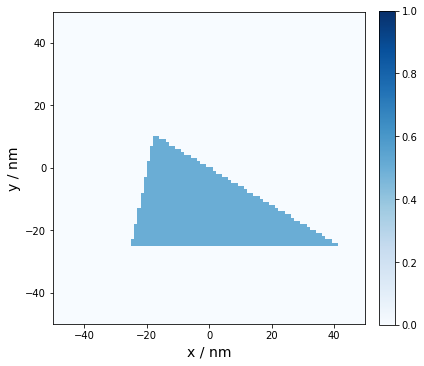

In [21]:
plot_2d(X,Y,Z,P)

In [30]:
Prot = rotate_bulk(P,90,90,90)

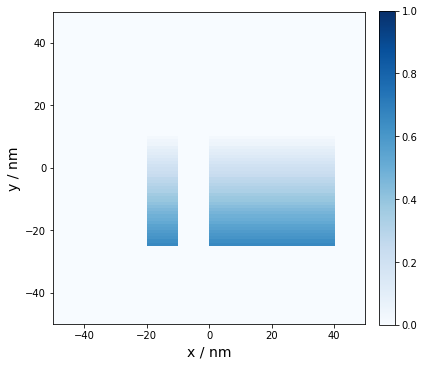

In [31]:
plot_2d(X,Y,Z,Prot)

- projection direction is normal to the plane of the image
- [0,0,0] angles corresponds to a vector pointing in positive z [0,0,1]
https://math.stackexchange.com/questions/1637464/find-unit-vector-given-roll-pitch-and-yaw

In [39]:
def angle_to_vector(ax,ay,az):
    θ = az * np.pi/180 # yaw
    ϕ = ax * np.pi/180 # pitch
    ψ = ay * np.pi/180 # roll
    
    x = -np.sin(ψ)*np.cos(θ)-np.cos(ψ)*np.sin(ϕ)*np.sin(θ)
    y = np.sin(ψ)*np.sin(θ)-np.cos(ψ)*np.sin(ϕ)*np.cos(θ)
    z = np.cos(ψ)*np.cos(ϕ)
    
    return x,y,z

In [78]:
x,y,z = angle_to_vector(30,-30,20)

(-1, 1)

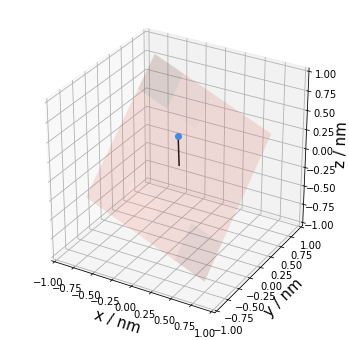

In [81]:
# plot in 3D for a single tilt

fig = plt.figure(figsize=(6,6))
ax = fig.gca(projection='3d')

# create x,y
xx, yy = np.meshgrid(np.linspace(-0.75,0.75,5), np.linspace(-0.75,0.75,5))

normal = [x,y,z]
d = 0#-np.array([0,0,0]).dot(normal)

# calculate corresponding z
zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

ax.plot_surface(xx, yy, zz, alpha=0.2,color='salmon')


ax.plot([0,x],[0,y],[0,z],color='k')
ax.plot([x],[y],[z],'o',color='dodgerblue')



# Add axis labels
plt.xlabel('x / nm', fontsize=15)
plt.ylabel('y / nm', fontsize=15)
ax.set_zlabel('z / nm', fontsize=15)

ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])




(-1, 1)

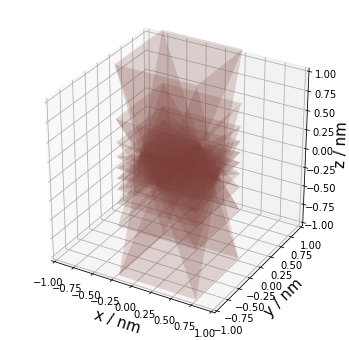

In [88]:
# plot in 3D for a tilt series
fig = plt.figure(figsize=(6,6))
ax1 = fig.gca(projection='3d')

ax,ay,az=0,0,0

for ax in np.linspace(-70,70,10):
    x,y,z = angle_to_vector(ax,ay,az)
    # create x,y
    xx, yy = np.meshgrid(np.linspace(-0.5,0.5,5), np.linspace(-0.5,0.5,5))

    normal = [x,y,z]
    d = 0#-np.array([0,0,0]).dot(normal)

    # calculate corresponding z
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    ax1.plot_surface(xx, yy, zz, alpha=0.2,color='salmon')

ax = 0
for ay in np.linspace(-70,70,10):
    x,y,z = angle_to_vector(ax,ay,az)
    # create x,y
    xx, yy = np.meshgrid(np.linspace(-0.5,0.5,5), np.linspace(-0.5,0.5,5))

    normal = [x,y,z]
    d = 0#-np.array([0,0,0]).dot(normal)

    # calculate corresponding z
    zz = (-normal[0] * xx - normal[1] * yy - d) * 1. /normal[2]

    ax1.plot_surface(xx, yy, zz, alpha=0.2,color='salmon')

# Add axis labels
plt.xlabel('x / nm', fontsize=15)
plt.ylabel('y / nm', fontsize=15)
ax1.set_zlabel('z / nm', fontsize=15)

ax1.set_xlim([-1,1])
ax1.set_ylim([-1,1])
ax1.set_zlim([-1,1])